# Bull Stearns: Predicting Volatility

Meet the boys:

-Adam, Ari, Brandt, and Ian.

*Note: This notebook can be run from top to bottom, but it takes about 4 hours to completely finish running* 

But, everything of relevance should be printed. Also, you can load in the main dataframes, functions and parameters needed by running the next few cells. That will allow you to run most of the cells in this notebook, if not all.

In [1]:
#!pip install wrds # Uncomment if in collab
# !pip install fredapi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
import wrds
import warnings
from fredapi import Fred
fred = Fred(api_key='37eb22bada238c97f282715480e7d897')
# Old Key: 0c6e1a63f22822c741ecbfb74bcf5c7d
import datetime

from arch import arch_model
import arch

from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

plt.style.use('fivethirtyeight')

warnings.filterwarnings("ignore")
# pd.set_option('display.float_format', lambda x: '%.5f' % x);

# pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
sns.set(rc={'figure.figsize':(11.7,8.27)})

db = wrds.Connection(wrds_username='bgreen41')
# db = wrds.Connection(wrds_username='iarzt')

Loading library list...
Done


### Main Data Files

Various Parameters:

In [2]:
lag_cols = ['lag_vol']  + [f'lag_vol_{month_lag}' for month_lag in range(2,13)]
predictor_cols = ['lag_ret','wti_lag_vol','np.log(mkt_cap)','vix','three_month_rate', 
                    'debt_to_equity','international_count','lm_litigious_count'] + lag_cols 

yhat_cols = ['hist_vol_1_year', 'hist_vol_2_year', 'hist_vol_5_year', 'hist_vol_all', 'lag_vol','ols_lag_vol_12_all', 
'ols_lag_vol_12_ts', 'ols_lag_vol_all', 'ols_lag_vol_ts', 'ols_max_all', 'ols_max_ts', 'rf','garch']

Functions used at various places in the code below:

In [3]:

def convert_to_sql(iterable):
    """Convert an iterable into a string that could be sent into an "In" statement in sql. Puts " ' " around each item and commas in between each item."""
    return f"""'{"', '".join(iterable)}'"""

def attach_info(df,link_col='gvkey',fields_to_pull=('tic','conm')):

    df_info = df_comp[['gvkey','tic','conm']].drop_duplicates()
    df_info = df_info[['gvkey'] + list(fields_to_pull)]

    return df.merge(df_info,on=link_col)


def load_df_X() -> pd.DataFrame:
    df_X = pd.read_csv('https://github.com/Brandt-moreThan4/Data/blob/main/df_X.csv?raw=true')
    df_X = df_X.rename(columns={'Unnamed: 0':'year','Unnamed: 1':'month','Unnamed: 2':'gvkey'})
    df_X = df_X.set_index(['year','month','gvkey']).unstack().swaplevel(axis=1) # Better way to do this?
    return df_X

def load_def_preds_all():
    df_preds_all = pd.read_csv('https://github.com/Brandt-moreThan4/Data/blob/main/df_preds_all_wgarch.csv?raw=true')
    df_preds_all = df_preds_all.rename(columns={'pred_vol':'garch'})
    # df_preds_all = attach_info(df_preds_all)

    return df_preds_all



These are the main dataframes that were created. If you load them in here, you can skip most of the code blocks.

In [5]:
df_X = load_df_X()
df_preds_all = load_def_preds_all()
df_all = df_X.stack(0).dropna() 
df_all2 = df_all.reset_index(level=2).rename(columns={'level_2':'gvkey'})
df_daily_1 = pd.read_csv('df_daily_1.csv')
df_daily_1['date'] =  pd.to_datetime(df_daily_1.date)
df2 = df_daily_1 # I know this is stupid.

## Data Adventures: 

There is a whole lot of data fun to be had. Because of that, after this data cleaning is over, we will save the appropriate files to csvs, if possible so that we don't have to go through this ordeal constantly, when no changes are made.

<br>

To start with, we need to compile all of the data we will need. We need to pull in fundamental data, macro data, unstructured variables, and daily pricing data. Then merge them all together in a way that makes sense.

### Security Fundamental and Pricing Data - Compustat
Step 1, done below, is to grab daily quarterly fundamental data for all companies in the S&P 500.

In [178]:
# S&P 500 Only fundamental data. Takes 3 minutes to run.

# Get tickers for S&P 500 companies
ticks = pd.read_csv('https://github.com/Brandt-moreThan4/UT-Projects/blob/master/Finance/Index_Replication/spy_ticker.txt?raw=true')
ticks = ticks.iloc[:,0].to_list() + [ticks.columns[0]]

# Now, query compustat database for only those tickers.
query_string = f"""SELECT * from comp.fundq where tic In({convert_to_sql(ticks)}) and datafmt = 'STD' and datadate between '1995-12-31' and '2020-12-31' order by datadate desc"""
df_comp = db.raw_sql(query_string)


df_comp['datadate'] = pd.to_datetime(df_comp['datadate'])
df_comp['year_month'] = df_comp['datadate'].dt.strftime('%Y-%m') # Need this column  for merging later on.
df_comp['gvkey'] = df_comp['gvkey'].astype(int) # Gvkey needs to be an int so that it can merge smoothly with unstructutred later
df_comp = df_comp.sort_values(by=['gvkey','datadate'])
df_comp['debt_to_equity'] = df_comp['ltq']/df_comp['atq']

print(df_comp.shape)
df_comp.head(2)

(45435, 649)


,gvkey,datadate,fyearq,fqtr,fyr,indfmt,consol,popsrc,datafmt,tic,cusip,conm,acctchgq,acctstdq,adrrq,ajexq,ajpq,bsprq,compstq,curcdq,curncdq,currtrq,curuscnq,datacqtr,datafqtr,finalq,ogmq,rp,scfq,srcq,staltq,updq,apdedateq,fdateq,pdateq,rdq,acchgq,acomincq,acoq,actq,altoq,ancq,anoq,aociderglq,aociotherq,aocipenq,aocisecglq,aol2q,aoq,apq,aqaq,aqdq,aqepsq,aqpl1q,aqpq,arcedq,arceepsq,arceq,atq,aul3q,billexceq,capr1q,capr2q,capr3q,capsftq,capsq,ceiexbillq,ceqq,cheq,chq,cibegniq,cicurrq,ciderglq,cimiiq,ciotherq,cipenq,ciq,cisecglq,citotalq,cogsq,csh12q,cshfd12,cshfdq,cshiq,cshopq,cshoq,cshprq,cstkcvq,cstkeq,cstkq,dcomq,dd1q,deracq,deraltq,derhedglq,derlcq,derlltq,diladq,dilavq,dlcq,dlttq,doq,dpacreq,dpactq,dpq,dpretq,drcq,drltq,dteaq,dtedq,dteepsq,dtepq,dvintfq,dvpq,epsf12,epsfi12,epsfiq,epsfxq,epspi12,epspiq,epspxq,epsx12,esopctq,esopnrq,esoprq,esoptq,esubq,fcaq,ffoq,finacoq,finaoq,finchq,findlcq,findltq,finivstq,finlcoq,finltoq,finnpq,finreccq,finrecltq,finrevq,finxintq,finxoprq,gdwlamq,gdwlia12,gdwliaq,gdwlid12,gdwlidq,gdwlieps12,gdwliepsq,gdwlipq,gdwlq,glaq,glcea12,glceaq,glced12,glcedq,glceeps12,glceepsq,glcepq,gldq,glepsq,glivq,glpq,hedgeglq,ibadj12,ibadjq,ibcomq,ibmiiq,ibq,icaptq,intaccq,intanoq,intanq,invfgq,invoq,invrmq,invtq,invwipq,ivaeqq,ivaoq,ivltq,ivstq,lcoq,lctq,lltq,lnoq,lol2q,loq,loxdrq,lqpl1q,lseq,ltmibq,ltq,lul3q,mibnq,mibq,mibtq,miiq,msaq,ncoq,niitq,nimq,niq,nopiq,npatq,npq,nrtxtdq,nrtxtepsq,nrtxtq,obkq,oepf12,oeps12,oepsxq,oiadpq,oibdpq,opepsq,optdrq,optfvgrq,optlifeq,optrfrq,optvolq,piq,pllq,pnc12,pncd12,pncdq,pnceps12,pncepsq,pnciapq,pnciaq,pncidpq,pncidq,pnciepspq,pnciepsq,pncippq,pncipq,pncpd12,pncpdq,pncpeps12,pncpepsq,pncpq,pncq,pncwiapq,pncwiaq,pncwidpq,pncwidq,pncwiepq,pncwiepsq,pncwippq,...,afudciy,amcy,aolochy,apalchy,aqay,aqcy,aqdy,aqepsy,aqpy,arcedy,arceepsy,arcey,capxy,cdvcy,chechy,cibegniy,cicurry,cidergly,cimiiy,ciothery,cipeny,cisecgly,citotaly,ciy,cogsy,cshfdy,cshpry,cstkey,depcy,derhedgly,dilady,dilavy,dlcchy,dltisy,dltry,doy,dpcy,dprety,dpy,dteay,dtedy,dteepsy,dtepy,dvpy,dvy,epsfiy,epsfxy,epspiy,epspxy,esubcy,esuby,exrey,fcay,ffoy,fiaoy,fincfy,finrevy,finxinty,finxopry,fopoxy,fopoy,fopty,fsrcoy,fsrcty,fuseoy,fusety,gdwlamy,gdwliay,gdwlidy,gdwliepsy,gdwlipy,glay,glceay,glcedy,glceepsy,glcepy,gldy,glepsy,glivy,glpy,hedgegly,ibadjy,ibcomy,ibcy,ibmiiy,iby,intpny,invchy,itccy,ivacoy,ivchy,ivncfy,ivstchy,miiy,ncoy,niity,nimy,niy,nopiy,nrtxtdy,nrtxtepsy,nrtxty,oancfy,oepsxy,oiadpy,oibdpy,opepsy,optdry,optfvgry,optlifey,optrfry,optvoly,pdvcy,piy,plly,pncdy,pncepsy,pnciapy,pnciay,pncidpy,pncidy,pnciepspy,pnciepsy,pncippy,pncipy,pncpdy,pncpepsy,pncpy,pncwiapy,pncwiay,pncwidpy,pncwidy,pncwiepsy,pncwiepy,pncwippy,pncwipy,pncy,prcay,prcdy,prcepsy,prcpdy,prcpepsy,prcpy,prstkccy,prstkcy,prstkpcy,rcay,rcdy,rcepsy,rcpy,rdipay,rdipdy,rdipepsy,rdipy,recchy,revty,rray,rrdy,rrepsy,rrpy,saley,scstkcy,setay,setdy,setepsy,setpy,sivy,spcedpy,spcedy,spceepspy,spceepsy,spcepy,spcey,spidy,spiepsy,spioay,spiopy,spiy,sppey,sppivy,spstkcy,srety,sstky,stkcoy,stkcpay,tdcy,tfvcey,tiey,tiiy,tsafcy,txachy,txbcofy,txbcoy,txdcy,txdiy,txpdy,txty,txwy,uaolochy,udfccy,udvpy,ufretsdy,ugiy,uniamiy,unopincy,unwccy,uoisy,updvpy,uptacy,uspiy,ustdncy,usubdvpy,utfdocy,utfoscy,utmey,uwkcapcy,wcapchy,wcapcy,wday,wddy,wdepsy,wdpy,xidocy,xidoy,xinty,xiy,xopry,xoptdqpy,xoptdy,xoptepsqpy,xoptepsy,xoptqpy,xopty,xrdy,xsgay,iid,exchg,cik,costat,fic,cshtrq,dvpspq,dvpsxq,mkvaltq,prccq,prchq,prclq,adjex,year_month,debt_to_equity
45146,1045,1995-12-31,1995.0,4.0,12.0,INDL,C,D,STD,AAL,02376R102,AMERICAN AIRLINES GROUP INC,None,None,NaN,2.0,2.0,None,None,USD,USD,1.0,NaN,1995Q4,1995Q4,Y,None,Q,7.0,53.0,None,3.0,None,None,None,1996-01-18,0.0,NaN,494.0,3137.0,NaN,16419.0,NaN,NaN,NaN,NaN,NaN,NaN,2854.0,817.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19556.0,NaN,NaN,NaN,NaN,NaN,NaN,2239.0,NaN,3642.0,901.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3583.0,76.80,NaN,NaN,NaN,NaN,76.4,76.2,NaN,0.0,76.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,350.0,7052.0,0.0,NaN,6659.0,312.0,NaN,N

We will also need daily data for all of those same companies. Below is still using compustat, but now we want daily pricing data:

In [179]:
# Takes 3ish minutes
# query_string = f"""SELECT * from comp.secd where tic In({convert_to_sql(ticks)}) and datadate between '1995-12-31' and '2020-12-31' order by datadate asc, gvkey"""
query_string = f"""SELECT gvkey, tic,conm,prccd,ajexdi,datadate from comp.secd where tic In({convert_to_sql(ticks)}) and datadate between '1995-12-31' and '2020-12-31' order by datadate asc, gvkey"""
df_data = db.raw_sql(query_string)

Now, clean up that data to remove the unnecessary columns and create new relevant variables.

In [180]:
# Expected Cell Run Time: 10 seconds

# Creating Date Variables. We do not need to do any shifting of these dates, because they are daily data so we can assume we would have the information at the end of day
df_data['date'] = pd.to_datetime(df_data['datadate'])
df_data['year'] = df_data.date.dt.year
df_data['month'] = df_data.date.dt.month
# df_data['week'] = df_data.date.dt.isocalendar().week
df_data['day'] = df_data.date.dt.day

df_data = df_data.sort_values(['gvkey','date'])

df_data['price'] = df_data.prccd / df_data.ajexdi # Adjust for splits

# Get the continuously compounded returns. A lot of the papers do it this way.
df_data['log_price'] = np.log(df_data.price)
df_data['ret'] = df_data.groupby('gvkey')['log_price'].shift(0) - df_data.groupby('gvkey')['log_price'].shift(1)
df_data = df_data.dropna(subset=['ret'])

relevant_cols = ['gvkey', 'tic','conm','prccd','date', 'year', 'month', 'day', 'price', 'log_price', 'ret']
df_daily = df_data[relevant_cols].copy()
df_daily['gvkey'] = df_daily['gvkey'].astype(int) # Convert gvkeys to integer again

print(df_daily.shape)
df_daily.head(3)

(2692007, 11)


,gvkey,tic,conm,prccd,date,year,month,day,price,log_price,ret
323022,1045,AAL,AMERICAN AIRLINES GROUP INC,24.88,2013-12-10,2013,12,10,24.88,3.214064,0.011318
323494,1045,AAL,AMERICAN AIRLINES GROUP INC,25.99,2013-12-11,2013,12,11,25.99,3.257712,0.043648
323966,1045,AAL,AMERICAN AIRLINES GROUP INC,25.45,2013-12-12,2013,12,12,25.45,3.236716,-0.020996


### Macro Data

Our macro data comes directly from FRED. We are only grabbing daily macro data so the merging is not too difficult. The only tricky thing is that we occassionaly have data points for stocks, where there is not a matching macro data point. When that occurrs, we will interpolate the macro data point. We think this is reasonable as we think the interpolated value is likely closest to what people estimated in real-time.

VIX

In [181]:
vix = pd.DataFrame(fred.get_series_latest_release('VIXCLS')).reset_index().rename(columns={0:'vix', 'index':'date'})
vix['date'] = pd.to_datetime(vix['date'])

West Texas Intermediate Crude Oil

In [182]:
wti = pd.DataFrame(fred.get_series_latest_release('DCOILWTICO')).reset_index().rename(columns={0:'wti', 'index':'date'})
wti['date'] = pd.to_datetime(wti['date'])

Three Month Treasury Rate

In [183]:
three_month = pd.DataFrame(fred.get_series_latest_release('DTB3')).reset_index().rename(columns={0:'three_month_rate', 'index':'date'})
three_month['date'] = pd.to_datetime(three_month['date'])

In [184]:
# Now merge those in:
df_daily = pd.merge(df_daily, vix, how='left', on='date')
df_daily = pd.merge(df_daily, wti, how='left', on='date')
df_daily = pd.merge(df_daily, three_month, how='left', on='date')

And now the daily data has the macro vars attached!

In [185]:
df_daily.head(2)

,gvkey,tic,conm,prccd,date,year,month,day,price,log_price,ret,vix,wti,three_month_rate
0,1045,AAL,AMERICAN AIRLINES GROUP INC,24.88,2013-12-10,2013,12,10,24.88,3.214064,0.011318,13.91,98.32,0.07
1,1045,AAL,AMERICAN AIRLINES GROUP INC,25.99,2013-12-11,2013,12,11,25.99,3.257712,0.043648,15.42,97.25,0.07


But, we still need to interpolate the missing values. This is done below. We also calculate the return for WTI, because we will want to calculate vol of WTI return later as well.

In [186]:
df_daily['vix'] = df_daily['vix'].interpolate(method='linear', limit_direction='forward')
df_daily['wti'] = df_daily['wti'].interpolate(method='linear', limit_direction='forward')
df_daily['three_month_rate'] = df_daily['three_month_rate'].interpolate(method='linear', limit_direction='forward')

# For oil, we also want to calculate the returns.
df_daily['wti_ret'] = np.log(df_daily.groupby('gvkey')['wti'].shift(0)) - np.log(df_daily.groupby('gvkey')['wti'].shift(1))
df_daily = df_daily.dropna(subset=['wti_ret'])

#### Load In Unstructured Data:
The below few cell blocks get a bit messy. It's difficult to merge quarterly data onto daily data.

In [187]:
# df_unstructured = pd.read_csv('unstructured_vars_sp500.csv')
df_unstructured = pd.read_csv('https://github.com/Brandt-moreThan4/Data/blob/main/unstructured_vars_sp500.csv?raw=True')
df_unstructured['data_date'] = pd.to_datetime(df_unstructured['data_date'])
df_unstructured['file_date'] = pd.to_datetime(df_unstructured['file_date'])
df_unstructured['data_year_month'] = df_unstructured['data_date'].dt.strftime('%Y-%m')
print(df_unstructured.shape)
df_unstructured.head()

(36614, 15)


,gvkey,data_date,data_year_month,file_year_month,type,international_count,rev_growth_count,rev_slow_count,expense_growth_count,expense_slow_count,lm_positive_count,lm_negative_count,lm_uncertainty_count,lm_litigious_count,file_date
0,1045,2000-06-01,2000-06,2000-07,10-Q,14,17,3,14,0,25,135,58,189,2000-07-28
1,1045,2001-03-01,2001-03,2001-04,10-Q,15,4,6,11,1,13,122,71,118,2001-04-24
2,1045,2001-06-01,2001-06,2001-08,10-Q,14,9,10,20,3,18,159,103,118,2001-08-13
3,1045,2001-09-01,2001-09,2001-10,10-Q,17,1,14,24,9,31,230,164,120,2001-10-25
4,1045,2002-03-01,2002-03,2002-04,10-Q,8,0,9,11,2,5,121,61,91,2002-04-18


Some summary stats, for the curious among us:

In [188]:
df_unstructured.describe().round()

,gvkey,international_count,rev_growth_count,rev_slow_count,expense_growth_count,expense_slow_count,lm_positive_count,lm_negative_count,lm_uncertainty_count,lm_litigious_count
count,36614.0,36614.0,36614.0,36614.0,36614.0,36614.0,36614.0,36614.0,36614.0,36614.0
mean,39866.0,116.0,25.0,14.0,19.0,15.0,157.0,695.0,467.0,754.0
std,56003.0,139.0,19.0,14.0,19.0,15.0,153.0,771.0,446.0,1319.0
min,1045.0,0.0,0.0,0.0,0.0,0.0,-8.0,0.0,0.0,2.0
25%,5959.0,26.0,11.0,5.0,7.0,5.0,57.0,225.0,172.0,144.0
50%,11228.0,72.0,20.0,10.0,14.0,11.0,109.0,465.0,320.0,344.0
75%,31877.0,154.0,33.0,19.0,25.0,20.0,210.0,903.0,629.0,828.0
max,316056.0,2247.0,167.0,144.0,280.0,195.0,2808.0,26949.0,9680.0,76289.0


#### Merge Fundamental and Unstructured Data

We merge in the fundamental adn unstructured based on the column 'year_month' because sometimes the datadata that is grabbed from edgar was a day before or after the datadate in WRDS, meaning that if we merged for an exact date, we miss a lot of matches. 

We do an inner merge because we only want to look at companies where we have complete data.

In [189]:
df_fund_unstructured = pd.merge(df_comp, df_unstructured, how='inner', left_on=['gvkey', 'year_month'], right_on=['gvkey', 'data_year_month'])

# Keep only the columns we care about in df_comp
df_fund_unstructured = df_fund_unstructured[['gvkey','datadate','file_date','type','debt_to_equity','cshoq','international_count', 'lm_litigious_count','data_year_month']].sort_values(['gvkey','file_date'])
df_fund_unstructured['file_date_shifted'] =  df_fund_unstructured['file_date'] + pd.Timedelta(30,'days')
df_fund_unstructured['merge_year'] = df_fund_unstructured['file_date_shifted'].dt.year
df_fund_unstructured['merge_month'] = df_fund_unstructured['file_date_shifted'].dt.month

print(df_fund_unstructured.shape)
df_fund_unstructured.head()

(33148, 12)


,gvkey,datadate,file_date,type,debt_to_equity,cshoq,international_count,lm_litigious_count,data_year_month,file_date_shifted,merge_year,merge_month
0,1045,2000-06-30,2000-07-28,10-Q,0.734071,149.958,14,189,2000-06,2000-08-27,2000,8
1,1045,2001-03-31,2001-04-24,10-Q,0.727406,153.694,15,118,2001-03,2001-05-24,2001,5
2,1045,2001-06-30,2001-08-13,10-Q,0.767602,154.408,14,118,2001-06,2001-09-12,2001,9
3,1045,2001-09-30,2001-10-25,10-Q,0.804303,154.482,17,120,2001-09,2001-11-24,2001,11
4,1045,2002-03-31,2002-04-18,10-Q,0.876953,155.119,8,91,2002-03,2002-05-18,2002,5


#### Merge Fundamental + Unstructured to Daily Data:

We may want to also consider the quarterly variables in some of our models that use daily data so we merge all that in too. The important thing to note here is that we are doing the merge based on the datadate for daily data but the file date for the quarterly. This is because the file date is when the quarterly data actually became available (scraped from Edgar) and when we are building models later we want each row to represent the data available at that date.

After merging in the 

In [190]:
df_daily_1 = df_daily[df_daily.gvkey.isin(df_fund_unstructured.gvkey.unique())] # Filter df_daily to only include companies that we have fundamental data for.
df_daily_1 = pd.merge(df_daily_1, df_fund_unstructured, how='left', left_on=['gvkey', 'year','month'], right_on=['gvkey', 'merge_year','merge_month']) 
df_daily_1['cshoq'] = df_daily_1.groupby(['gvkey'])['cshoq'].fillna(method='ffill')
df_daily_1['debt_to_equity'] = df_daily_1.groupby(['gvkey'])['debt_to_equity'].fillna(method='ffill')
df_daily_1['international_count'] = df_daily_1.groupby(['gvkey'])['international_count'].fillna(method='ffill')
df_daily_1['lm_litigious_count'] = df_daily_1.groupby(['gvkey'])['lm_litigious_count'].fillna(method='ffill')
df_daily_1['mkt_cap'] = df_daily_1.cshoq * df_daily_1.prccd

df_daily_1 = df_daily_1.drop(columns=['datadate','file_date','type','data_year_month', 'file_date_shifted', 'merge_year', 'merge_month'])
df_daily_1 = df_daily_1.dropna() # There are still some NAs for a few companies where there the data start periods don't align perfectly

print(df_daily_1.shape)
print(df_daily_1.gvkey.nunique())
df_daily_1.head()

(2157363, 20)
492


,gvkey,tic,conm,prccd,date,year,month,day,price,log_price,ret,vix,wti,three_month_rate,wti_ret,debt_to_equity,cshoq,international_count,lm_litigious_count,mkt_cap
54,1045,AAL,AMERICAN AIRLINES GROUP INC,36.10,2014-03-03,2014,3,3,36.10,3.586293,-0.022731,16.00,105.34,0.05,0.023630,1.064596,261.069,349.0,3173.0,9424.59090
55,1045,AAL,AMERICAN AIRLINES GROUP INC,37.34,2014-03-04,2014,3,4,37.34,3.620065,0.033772,14.10,103.64,0.05,-0.016270,1.064596,261.069,349.0,3173.0,9748.31646
56,1045,AAL,AMERICAN AIRLINES GROUP INC,37.86,2014-03-05,2014,3,5,37.86,3.633895,0.013830,13.89,101.75,0.06,-0.018405,1.064596,261.069,349.0,3173.0,9884.07234
57,1045,AAL,AMERICAN AIRLINES GROUP INC,38.81,2014-03-06,2014,3,6,38.81,3.658678,0.024783,14.21,101.82,0.05,0.000688,1.064596,261.069,349.0,3173.0,10132.08789
58,1045,AAL,AMERICAN AIRLINES GROUP INC,39.02,2014-03-07,2014,3,7,39.02,3.664074,0.005396,14.11,102.82,0.06,0.009773,1.064596,261.069,349.0,3173.0,10186.91238


### Save Data:

We don't want to have to do the above every time, so we save this already cleaned data in a csv and it can be read back in directly if there were no changes to the above.


In [191]:
# df_daily_1.to_csv('df_daily_1.csv',index=False) # Save it, if necessary.
df_daily_1 = pd.read_csv('df_daily_1.csv') # Read it in, if necessary
df_daily_1['date'] = pd.to_datetime(df_daily_1['date'])
print(df_daily_1.shape)
df_daily_1.head(2)

(2157363, 20)


,gvkey,tic,conm,prccd,date,year,month,day,price,log_price,ret,vix,wti,three_month_rate,wti_ret,debt_to_equity,cshoq,international_count,lm_litigious_count,mkt_cap
0,1045,AAL,AMERICAN AIRLINES GROUP INC,36.10,2014-03-03,2014,3,3,36.10,3.586293,-0.022731,16.0,105.34,0.05,0.02363,1.064596,261.069,349.0,3173.0,9424.59090
1,1045,AAL,AMERICAN AIRLINES GROUP INC,37.34,2014-03-04,2014,3,4,37.34,3.620065,0.033772,14.1,103.64,0.05,-0.01627,1.064596,261.069,349.0,3173.0,9748.31646


In [52]:
# # Create a smaller data set to play with:
# df2 = df_daily_1[df_daily_1.tic.isin(['AAPL','GE','F','NFLX','AMZN'])].copy().sort_values(['gvkey','date'])
# print(df2.shape)
# df2.head()

In [253]:
df2 = df_daily_1 # I know this is stupid, but this line is here so we don't have to change a bunch of our code below. 
print(df2.shape)
df2.head(1)

(2157363, 20)


,gvkey,tic,conm,prccd,date,year,month,day,price,log_price,ret,vix,wti,three_month_rate,wti_ret,debt_to_equity,cshoq,international_count,lm_litigious_count,mkt_cap
0,1045,AAL,AMERICAN AIRLINES GROUP INC,36.1,2014-03-03,2014,3,3,36.1,3.586293,-0.022731,16.0,105.34,0.05,0.02363,1.064596,261.069,349.0,3173.0,9424.5909


### Data Adventures Part 2:

That was just reading in the data. Now we need to massage the data to get into the format that will be fed into our models.

#### Lookup Tables

In the code below, we sometimes need to reference the end of month value or the quarterly values. It is easier for us to first calculate what those values are here, and create lookup tables for easy access later on. We do this for macro variables and the quaretly variables that do not change often, but we also do it for our newy concocted variables such as previous months volatility.

In [192]:
# Get the new lookup tables for end-of-month macro vars. 
vix = df_daily_1.groupby(['year','month'])['vix'].last()
wti = df_daily_1.groupby(['year','month'])['wti'].last()
three_month = df_daily_1.groupby(['year','month'])['three_month_rate'].last()

In [194]:
# Creating a lookup table for certain values. It's better to do this once up here and reference it later.
# Summing rets because these are continuously compounded rates.

monthly_vals = df2.groupby(['gvkey','year','month'])[['ret','wti_ret']].agg(['std','sum']).rename(columns={'std':'vol','sum':'ret'}) #.droplevel(level=0,axis='columns')
monthly_vals.head(2)
# monthly_vals.loc[1690].loc[:(2001,(5)),('ret','vol')].iloc[-2]# Example of how it is accessed

ret             wti_ret          
                       vol       ret       vol       ret
gvkey year month                                        
1045  2014 3      0.022153 -0.008976  0.011597 -0.012815
           4      0.025371 -0.042702  0.010641 -0.014878

Same as above, except now we are doing it for the quarterly values for each company. For each company and at each month. Just grab the most recent quarterly value available. The proper merging was done in the data section far above when these variables were brought in, so we do not have have to worry about look ahead bias here.

In [195]:
quarterly_cols = ['debt_to_equity','mkt_cap','international_count', 'lm_litigious_count']
quarterly_vals_monthly = df2.groupby(['gvkey','year','month'])[quarterly_cols].last()
quarterly_vals_monthly.head(3)
# quarterly_vals_monthly.loc[1690].loc[:(2001,2),'international_count'].iloc[-2] # Example of how to access it

debt_to_equity      mkt_cap  international_count  lm_litigious_count
gvkey year month                                                                      
1045  2014 3            1.064596   9555.12540                349.0              3173.0
           4            1.064596   9155.68983                349.0              3173.0
           5            0.974964  26102.11248                166.0              1545.0

### 'X' DataFrame Creation:
We now  need to build out our "X" matrix. We need to construct the values that will be our independent and dependent variables. After this loop, we will use this data to get out predictions. It's inefficient, but intuitive to understand.

In [112]:
# This line is here, in case we wanted to run the below code with a random subset of companies
# gvkeys = np.random.choice(list(df2.gvkey.unique(),100,replace=True)) # Sample 100 companies only

In [114]:
lag_cols = ['lag_vol']  + [f'lag_vol_{month_lag}' for month_lag in range(2,13)]
gvkeys = list(df2.gvkey.unique()) # get the unique companies
X_years = range(2000,2021) # We start training in 2000, so we want to build out our predictors df to go back this far.
row_index_X = pd.MultiIndex.from_product([X_years,range(1,13)]) # rows should be years, and 12 months.
new_cols = ['real_vol','lag_vol','hist_vol_all','hist_vol_5_year','hist_vol_2_year','hist_vol_1_year','lag_ret'] # Columns we need to fill in data for.

col_index = pd.MultiIndex.from_product([gvkeys,new_cols])
df_X = pd.DataFrame(index=row_index_X,columns=col_index)
df_X.head() # This is what we need to populate

1045                                                                                  1075                                                                                  1078                                                                                  1161                                                                                  1209                                                                                  1230                                                                                  1300                                                                                  1327                                                                                  1380                                                                                  1440                                                                                  1447                                                                                  1449                         \
       real_vol lag_vol hist_vol_all hist_vol_5_year hist_vol_2_year hist_vol_1_year lag_ret real_vol lag_vol hist_vol_all hist_vol_5_year hist_vol_2_year hist_vol_1_year lag_ret real_vol lag_vol hist_vol_all hist_vol_5_year hist_vol_2_year hist_vol_1_year lag_ret real_vol lag_vol hist_vol_all hist_vol_5_year hist_vol_2_year hist_vol_1_year lag_ret real_vol lag_vol hist_vol_all hist_vol_5_year hist_vol_2_year hist_vol_1_year lag_ret real_vol lag_vol hist_vol_all hist_vol_5_year hist_vol_2_year hist_vol_1_year lag_ret real_vol lag_vol hist_vol_all hist_vol_5_year hist_vol_2_year hist_vol_1_year lag_ret real_vol lag_vol hist_vol_all hist_vol_5_year hist_vol_2_year hist_vol_1_year lag_ret real_vol lag_vol hist_vol_all hist_vol_5_year hist_vol_2_year hist_vol_1_year lag_ret real_vol lag_vol hist_vol_all hist_vol_5_year hist_vol_2_year hist_vol_1_year lag_ret real_vol lag_vol hist_vol_all hist_vol_5_year hist_vol_2_year hist_vol_1_year lag_ret real_vol lag_vol hist_vol_all   
2000 1      NaN     NaN          NaN             NaN             NaN             NaN     NaN      NaN     NaN          NaN             NaN             NaN             NaN     NaN      NaN     NaN          NaN             NaN             NaN             NaN     NaN      NaN     NaN          NaN             NaN             NaN             NaN     NaN      NaN     NaN          NaN             NaN             NaN             NaN     NaN      NaN     NaN          NaN             NaN             NaN             NaN     NaN      NaN     NaN          NaN             NaN             NaN             NaN     NaN      NaN     NaN          NaN             NaN             NaN             NaN     NaN      NaN     NaN          NaN             NaN             NaN             NaN     NaN      NaN     NaN          NaN             NaN             NaN             NaN     NaN      NaN     NaN          NaN             NaN             NaN             NaN     NaN      NaN     NaN          NaN   
     2      NaN     NaN          NaN             NaN             NaN             NaN     NaN      NaN     NaN          NaN             NaN             NaN             NaN     NaN      NaN     NaN          NaN             NaN             NaN             NaN     NaN      NaN     NaN          NaN             NaN             NaN             NaN     NaN      NaN     NaN          NaN             NaN             NaN             NaN     NaN      NaN     NaN          NaN             NaN             NaN             NaN     NaN      NaN     NaN          NaN             NaN             NaN             NaN     NaN      NaN     NaN          NaN             NaN             NaN             NaN     NaN      NaN     NaN          NaN             NaN             NaN             NaN     NaN      NaN     NaN          NaN             NaN             NaN             NaN     NaN      NaN     NaN          NaN             NaN             NaN             NaN     NaN      NaN     NaN          NaN   
     3      NaN     NaN          NaN             NaN             

Loop through all years, months, and gvkeys. For each of the inner-most loop, we extract the relevant predictors and populate them into the df_X dataframe.

In [115]:
# Takes 40 seconds to run for five companies. About 45 minutes for all 500.
df_X = pd.DataFrame(index=row_index_X,columns=col_index)

for year in X_years: 
    for month in range(1,13):

        # We need to be able to filter the dataframes based on information we will have at that time.
        prediction_date = pd.to_datetime(f'{str(year)}-{month}-01') # Our prediction date, will technichally be the end of month day. This date just makes filtering easy

        # df_past = df2[df2.date < prediction_date] # Only look at past data as of this point.

        for gvkey in gvkeys: 
            
            year_month = (year,month) 
            if year_month not in monthly_vals.loc[gvkey].index: # Does this gvkey have vol data for this month? If not, skip it.
                # This is necessary so that we don't try to do any of the below calculations when it would be nonsense
                continue
            if monthly_vals.loc[gvkey].loc[:year_month].shape[0] <= 60: # Does this gvkey have 5 years of monthly data at this point in time?
                # This is necessary so that we don't try to do any of the below calculations with not enough data.
                continue

            # Filter data df to only look at data for the company in question.
            df_past_tic = df2[(df2.gvkey == gvkey) & (df2.date < prediction_date)] 

            # Grab dependent var value
            df_X.loc[(year_month),(gvkey,'real_vol')] = monthly_vals.loc[(gvkey,year,month),('ret','vol')] # This is our y variable, that we want to predict.
            

            # Get historical volatilities, for various look back periods.
            df_X.loc[year_month,(gvkey,'lag_vol')] = monthly_vals.loc[gvkey].loc[:(year,(month)),('ret','vol')].iloc[-2] # Get last month's vol.
            df_X.loc[(year,month),(gvkey,'hist_vol_all')] = df_past_tic['ret'].std() # Entire history of vol. 
            df_X.loc[(year,month),(gvkey,'hist_vol_5_year')] = df_past_tic[df_past_tic.date >= (prediction_date - pd.Timedelta(365*5,unit='days'))]['ret'].std()
            df_X.loc[(year,month),(gvkey,'hist_vol_2_year')] = df_past_tic[df_past_tic.date >= (prediction_date - pd.Timedelta(365*2,unit='days'))]['ret'].std()
            df_X.loc[(year,month),(gvkey,'hist_vol_1_year')] = df_past_tic[df_past_tic.date >= (prediction_date - pd.Timedelta(365,unit='days'))]['ret'].std()

            # Last month's return:
            df_X.loc[(year,month),(gvkey,'lag_ret')] = monthly_vals.loc[gvkey].loc[:(year,(month)),('ret','ret')].iloc[-2] 
            
            # This will grab the monthly vol lags for the months 2-12. 
            for month_lag in range(2,13): # this could bug out if we don't have a whole year of data?
                df_X.loc[(year,month),(gvkey,f'lag_vol_{month_lag}')] = monthly_vals.loc[gvkey].loc[:(year,month),('ret','vol')].iloc[(-1-month_lag)]


            # Populate the macro vars.
            df_X.loc[(year,month),(gvkey,'wti_lag_vol')] = monthly_vals.loc[gvkey].loc[:(year,month),('wti_ret','vol')].iloc[-2] 
            df_X.loc[(year,month),(gvkey,'vix')] = vix.loc[:(year,month)].iloc[-2] 
            df_X.loc[(year,month),(gvkey,'three_month_rate')] = three_month.loc[:(year,month)].iloc[-2] # Last month's ending value rate
            
            # Add in quartely values.
            df_X.loc[(year,month),(gvkey,'debt_to_equity')] = quarterly_vals_monthly.loc[gvkey].loc[:(year,month),'debt_to_equity'].iloc[-2]
            df_X.loc[(year,month),(gvkey,'mkt_cap')] = quarterly_vals_monthly.loc[gvkey].loc[:(year,month),'mkt_cap'].iloc[-2]
            df_X.loc[(year,month),(gvkey,'international_count')] = quarterly_vals_monthly.loc[gvkey].loc[:(year,month),'international_count'].iloc[-2]
            df_X.loc[(year,month),(gvkey,'lm_litigious_count')] = quarterly_vals_monthly.loc[gvkey].loc[:(year,month),'lm_litigious_count'].iloc[-2]


df_X = df_X.astype(float)
dfa = df_X[1690] # Have a dataframe for apple only, just for reference and play.
df_X.loc[2006:].head() # Showing After 2006 because the first 5 years have mostly NAs.

1045                                                                                   1075                                                                                       1078                                                                                      1161                                                                                  1209                                                                                   1230                                                                                      1300                                                                                   1327                                                                                       1380                                                                                      1440                                                                                   1447                                                                                       1449    \
       real_vol lag_vol hist_vol_all hist_vol_5_year hist_vol_2_year hist_vol_1_year lag_ret  real_vol   lag_vol hist_vol_all hist_vol_5_year hist_vol_2_year hist_vol_1_year   lag_ret  real_vol   lag_vol hist_vol_all hist_vol_5_year hist_vol_2_year hist_vol_1_year   lag_ret real_vol lag_vol hist_vol_all hist_vol_5_year hist_vol_2_year hist_vol_1_year lag_ret real_vol lag_vol hist_vol_all hist_vol_5_year hist_vol_2_year hist_vol_1_year lag_ret  real_vol   lag_vol hist_vol_all hist_vol_5_year hist_vol_2_year hist_vol_1_year   lag_ret real_vol lag_vol hist_vol_all hist_vol_5_year hist_vol_2_year hist_vol_1_year lag_ret  real_vol   lag_vol hist_vol_all hist_vol_5_year hist_vol_2_year hist_vol_1_year   lag_ret  real_vol   lag_vol hist_vol_all hist_vol_5_year hist_vol_2_year hist_vol_1_year   lag_ret real_vol lag_vol hist_vol_all hist_vol_5_year hist_vol_2_year hist_vol_1_year lag_ret  real_vol   lag_vol hist_vol_all hist_vol_5_year hist_vol_2_year hist_vol_1_year   lag_ret  real_vol   
2006 1      NaN     NaN          NaN             NaN             NaN             NaN     NaN  0.011345  0.007998     0.015218        0.015277        0.009200        0.009473 -0.003380  0.018163  0.011074     0.017777        0.017412        0.012171        0.011840  0.044602      NaN     NaN          NaN             NaN             NaN             NaN     NaN      NaN     NaN          NaN             NaN             NaN             NaN     NaN  0.025888  0.017429     0.027853        0.027622        0.021044        0.019636  0.027626      NaN     NaN          NaN             NaN             NaN             NaN     NaN       NaN       NaN          NaN             NaN             NaN             NaN       NaN  0.014552  0.020732     0.018887        0.018628        0.018558        0.020100  0.034494      NaN     NaN          NaN             NaN             NaN             NaN     NaN  0.012378  0.009069     0.020952        0.020519        0.011221        0.013341  0.000778  0.010530   
     2      NaN     NaN          NaN             NaN             NaN             NaN     NaN  0.007169  0.011345     0.015163        0.014921        0.009265        0.009695  0.030017  0.008990  0.018163     0.017784        0.017149        0.012380        0.012604  0.090155      NaN     NaN          NaN             NaN             NaN             NaN     NaN      NaN     NaN          NaN             NaN             NaN             NaN     NaN  0.016803  0.025888     0.027829        0.027444        0.020906        0.019780 -0.112165      NaN     NaN          NaN             NaN             NaN             NaN     NaN       NaN       NaN          NaN             NaN             NaN             NaN       NaN  0.019427  0.014552     0.018861        0.018564        0.018677        0.020325  0.199365      NaN     NaN          NaN             NaN             NaN             NaN     NaN  0.008256  0.012378     0.020849        0.020083        0.011246        0.013547  0.019056  0.009390   
     3      NaN     NaN  

In [116]:
# This just a stacked version of above. It may be easier to work with in certain instances.
# We can also drop NAs here, whereas if we try to do it in the above structure it get's real messy.
df_all = df_X.stack(0).dropna() 
df_all.head()

debt_to_equity  hist_vol_1_year  hist_vol_2_year  hist_vol_5_year  hist_vol_all  international_count   lag_ret   lag_vol  lag_vol_10  lag_vol_11  lag_vol_12  lag_vol_2  lag_vol_3  lag_vol_4  lag_vol_5  lag_vol_6  lag_vol_7  lag_vol_8  lag_vol_9  lm_litigious_count       mkt_cap  real_vol  three_month_rate    vix  wti_lag_vol
2005 8 2184        0.567806         0.018067         0.019507         0.037677      0.037667                186.0  0.111034  0.016997    0.011342    0.017415    0.016829   0.030919   0.013234   0.019488   0.012815   0.017921   0.016991   0.015828   0.016909               260.0   25150.99720  0.016830              3.34  11.57     0.018188
       4058        0.477369         0.012625         0.013591         0.019316      0.019308                 23.0  0.125874  0.013395    0.014676    0.011081    0.011034   0.008741   0.010368   0.017514   0.010710   0.014284   0.017292   0.010095   0.009413                42.0    8405.81728  0.010744              3.34  11.57     0.018188
       5047        0.825238         0.008929         0.010404         0.019836      0.019846                  6.0 -0.004338  0.008213    0.009315    0.009036    0.010565   0.009138   0.007602   0.009947   0.009680   0.006177   0.009010   0.009335   0.008805                32.0  365904.24000  0.007640              3.34  11.57     0.018188
       5125        0.421393         0.011165         0.009900         0.013363      0.013362                  9.0  0.108301  0.010476    0.022229    0.007408    0.010310   0.008158   0.007134   0.009569   0.009120   0.014982   0.007727   0.009151   0.009973                25.0    7988.06550  0.009711              3.34  11.57     0.018188
       7146        0.618087         0.011674         0.010236         0.013916      0.013914                 57.0  0.062279  0.010089    0.008959    0.014208    0.010965   0.009637   0.010339   0.007311   0.016867   0.008662   0.018209   0.008976   0.010904                76.0    4656.65942  0.010716              3.34  11.57     0.018188

#### Saving or Reading in Old csvs:

Uncomment out some of the below code if you want to save in a new data file.

In [197]:
# df_all.to_csv('df_X.csv')
# # df_X = pd.read_csv('https://github.com/Brandt-moreThan4/Data/blob/main/df_X.csv?raw=true')
# df_X = pd.read_csv('df_X.csv')
# df_X = df_X.rename(columns={'Unnamed: 0':'year','Unnamed: 1':'month','Unnamed: 2':'gvkey'})
# df_X = df_X.set_index(['year','month','gvkey']).unstack().swaplevel(axis=1) # Better way to do this?
# df_all = df_X.stack(0).dropna() 

df_X = load_df_X()
df_all = df_X.stack(0).dropna() 
df_all2 = df_all.reset_index(level=2).rename(columns={'level_2':'gvkey'})
df_X.head(2) # This looks slightly different than above, but the values are the same. Column order just gets weird

gvkey              1045           1075           1078           1161           1209           1230           1300           1327           1380           1440           1447           1449           1487           1598           1602           1632           1690           1704           1722           1878           1891           1913           2019           2086           2111           2136           2176           2184           2220           2285           2312           2403           2435           2574           2663           2710           2751           2817           2884           2968           2991           3026           3062           3121           3144           3170           3221           3226           3231           3243           3362           3413           3439           3504           3505           3532           3650           3735           3813           3835           3851           3897           4016           4029           4058    \
           debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity debt_to_equity   
year month                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
2005 8                NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN       0.567806            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN            NaN       0.477369   
     9                NaN            NaN    

## EDA

#### Below is a commented out EDA plot that we needed for presentation. Apple Vol

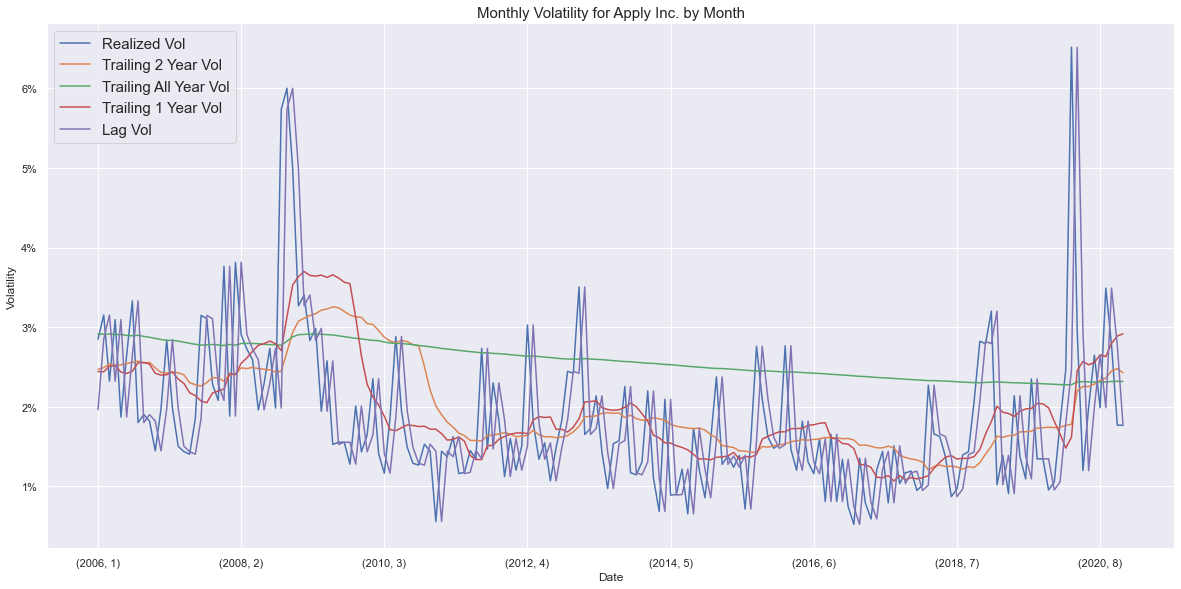

In [7]:
dfa = df_X[1690].dropna()
ha = dfa[['real_vol','hist_vol_all','hist_vol_2_year','lag_vol','hist_vol_1_year']]
ha = ha[['real_vol','hist_vol_2_year','hist_vol_all','hist_vol_1_year','lag_vol']]
ha.columns = ['Realized Vol','Trailing 2 Year Vol','Trailing All Year Vol','Trailing 1 Year Vol', 'Lag Vol']
ha.plot(figsize=(18,9))
ha.columns
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Monthly Volatility for Apply Inc. by Month',size= 15)
plt.legend(prop={'size':15})
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]);

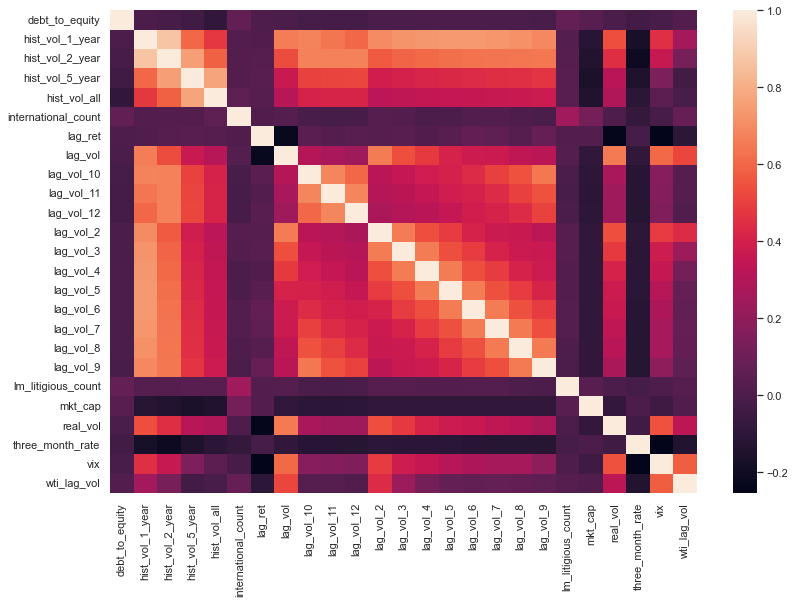

In [8]:
sns.heatmap(df_all.corr()); 

### In-Sample OLS Models

We can test the model where we lump all companies together, or we can test each separately.

In [9]:
# Restructure dataframe to make it possible to feed into models below.
df_all2 = df_all.reset_index(level=2).rename(columns={'level_2':'gvkey'})
df_all2.head()

gvkey  debt_to_equity  hist_vol_1_year  hist_vol_2_year  hist_vol_5_year  hist_vol_all  international_count   lag_ret   lag_vol  lag_vol_10  lag_vol_11  lag_vol_12  lag_vol_2  lag_vol_3  lag_vol_4  lag_vol_5  lag_vol_6  lag_vol_7  lag_vol_8  lag_vol_9  lm_litigious_count       mkt_cap  real_vol  three_month_rate    vix  wti_lag_vol
year month                                                                                                                                                                                                                                                                                                                                               
2005 8       2184        0.567806         0.018067         0.019507         0.037677      0.037667                186.0  0.111034  0.016997    0.011342    0.017415    0.016829   0.030919   0.013234   0.019488   0.012815   0.017921   0.016991   0.015828   0.016909               260.0   25150.99720  0.016830              3.34  11.57     0.018188
     8       4058        0.477369         0.012625         0.013591         0.019316      0.019308                 23.0  0.125874  0.013395    0.014676    0.011081    0.011034   0.008741   0.010368   0.017514   0.010710   0.014284   0.017292   0.010095   0.009413                42.0    8405.81728  0.010744              3.34  11.57     0.018188
     8       5047        0.825238         0.008929         0.010404         0.019836      0.019846                  6.0 -0.004338  0.008213    0.009315    0.009036    0.010565   0.009138   0.007602   0.009947   0.009680   0.006177   0.009010   0.009335   0.008805                32.0  365904.24000  0.007640              3.34  11.57     0.018188
     8       5125        0.421393         0.011165         0.009900         0.013363      0.013362                  9.0  0.108301  0.010476    0.022229    0.007408    0.010310   0.008158   0.007134   0.009569   0.009120   0.014982   0.007727   0.009151   0.009973                25.0    7988.06550  0.009711              3.34  11.57     0.018188
     8       7146        0.618087         0.011674         0.010236         0.013916      0.013914                 57.0  0.062279  0.010089    0.008959    0.014208    0.010965   0.009637   0.010339   0.007311   0.016867   0.008662   0.018209   0.008976   0.010904                76.0    4656.65942  0.010716              3.34  11.57     0.018188

#### Lumping everything together:

In [10]:
ols_all = ols(formula=f'real_vol ~ {" + ".join(lag_cols)}',data=df_all).fit() # Do pretty well by using just lags.
ols_all = ols(formula=f'real_vol ~ lag_vol',data=df_all).fit() # AR(1)
print(ols_all.summary())

                            OLS Regression Results                            
Dep. Variable:               real_vol   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                 5.320e+04
Date:                Sun, 15 May 2022   Prob (F-statistic):               0.00
Time:                        18:59:00   Log-Likelihood:             2.2943e+05
No. Observations:               72547   AIC:                        -4.589e+05
Df Residuals:                   72545   BIC:                        -4.588e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0064   6.38e-05     99.640      0.0

Including Macro Terms:

In [11]:
ols_all = ols(formula=f'real_vol ~ {" + ".join(predictor_cols)}',data=df_all).fit() # Macro stuff doesn't help much?
print(ols_all.summary())
# print(f'Coefs:')
# display(ols_all.params.to_frame().T)
# print(f'T Stats:')
# ols_all.tvalues.to_frame().T

                            OLS Regression Results                            
Dep. Variable:               real_vol   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     3897.
Date:                Sun, 15 May 2022   Prob (F-statistic):               0.00
Time:                        18:59:02   Log-Likelihood:             2.3595e+05
No. Observations:               72547   AIC:                        -4.719e+05
Df Residuals:                   72526   BIC:                        -4.717e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -1.329e-05    

#### Separating Out In-Sample Results by Company:

We create in-sample models for each company separately and then aggregate the values after done:

In [17]:
predictors = predictor_cols.copy()
df_coefs = pd.DataFrame(columns=predictor_cols)

for gvkey in df_all2.gvkey.unique():
    # print(f'{gvkey}')
    df_company = df_all2.query(f'gvkey == {gvkey}')
    ols_mod = ols(formula=f'real_vol ~ {" + ".join(predictor_cols)}',data=df_company).fit() 
    df_coefs.loc[gvkey] = ols_mod.params
    # print(ols_mod.summary(),'\n\n')  
    df_coefs.loc[gvkey,'R^2'] = ols_mod.rsquared
    df_coefs.loc[gvkey,'RMSE'] = ols_mod.mse_resid**.5
    df_coefs.loc[gvkey,'n'] = len(df_company)

df_coefs.index.name = 'gvkey'
df_coefs = df_coefs.reset_index()

df_coefs.head()

,gvkey,lag_ret,wti_lag_vol,np.log(mkt_cap),vix,three_month_rate,debt_to_equity,international_count,lm_litigious_count,lag_vol,lag_vol_2,lag_vol_3,lag_vol_4,lag_vol_5,lag_vol_6,lag_vol_7,lag_vol_8,lag_vol_9,lag_vol_10,lag_vol_11,lag_vol_12,R^2,RMSE,n
0,2184,-0.001803,0.034775,-0.008256,0.000515,0.001047,0.013293,1.560736e-06,-2.420381e-06,0.000551,0.010860,0.060644,-0.013955,-0.026900,0.017660,0.066226,-0.005883,0.106976,-0.148205,-0.130812,0.204011,0.336294,0.009622,185.0
1,4058,-0.014270,-0.022551,-0.003164,0.000882,-0.000378,0.009582,-1.957826e-07,1.112964e-06,-0.109411,-0.016815,0.049983,-0.143728,-0.072354,-0.085627,0.079005,-0.145226,0.049786,-0.041516,-0.074847,0.012778,0.543188,0.006716,185.0
2,5047,-0.023020,-0.003542,-0.008439,0.000522,0.000278,0.040158,-1.215199e-05,5.505238e-07,0.131647,0.110000,0.008418,-0.069089,-0.000842,0.018094,0.065337,-0.075693,-0.056906,0.067907,-0.070913,-0.064293,0.713273,0.007062,185.0
3,5125,0.004046,0.044445,-0.004083,0.000654,0.000155,0.022634,1.185334e-05,-6.358342e-07,0.022203,-0.105531,-0.006413,-0.179201,-0.004400,0.027448,-0.052872,-0.016423,-0.083868,-0.015402,0.043279,-0.103899,0.538047,0.005724,185.0
4,7146,-0.026849,0.004583,0.003366,0.000554,0.001440,0.003227,7.184949e-06,2.390421e-06,-0.224117,-0.071793,0.052097,-0.101231,-0.035751,-0.044642,0.008179,-0.051457,-0.011408,-0.101860,-0.044085,0.014916,0.423394,0.005067,185.0


Summary statistics on the coefficients and metrics help us to get an understanding for the big picture:

In [18]:
df_coefs.agg(['mean','median','std']).drop(columns=['gvkey']).T.round(4)

,mean,median,std
lag_ret,-0.0085,-0.0090,0.0264
wti_lag_vol,-0.0325,-0.0194,0.1233
np.log(mkt_cap),-0.0001,0.0004,0.0177
vix,0.0009,0.0008,0.0008
three_month_rate,0.0005,0.0007,0.0078
debt_to_equity,0.0299,0.0099,0.1770
international_count,-0.0000,-0.0000,0.0002
lm_litigious_count,0.0000,-0.0000,0.0001
lag_vol,-0.0004,0.0057,0.3796
lag_vol_2,-0.0196,-0.0166,0.1767


## OOS Predictions

But now comes the hard part. We want to see how we do when trying to predict out of sample.

Set Parameters:

In [58]:
gvkeys = df_X.stack(0).index.levels[2].values
pred_years = range(2011,2021)
row_index_preds = pd.MultiIndex.from_product([pred_years,range(1,13)])

# Pred cols are all of the different "models" we want to explore. It's actually a lot more than this now, but we add the other cols in the code loop below.
pred_cols = ['lag_vol','rf','hist_vol_all','hist_vol_5_year','hist_vol_2_year','hist_vol_1_year']
pred_cols_index = pd.MultiIndex.from_product([gvkeys,(pred_cols + ['real_vol'])])
df_preds = pd.DataFrame(index=row_index_preds,columns=pred_cols_index)
df_preds

1045                                                                               1075                                                                               1078                                                                               1161                                                                               1209                                                                               1230                                                                               1300                                                                               1327                                                                               1380                                                                               1440                                                                               1447                                                                               1449                                                                      \
        lag_vol   rf hist_vol_all hist_vol_5_year hist_vol_2_year hist_vol_1_year real_vol lag_vol   rf hist_vol_all hist_vol_5_year hist_vol_2_year hist_vol_1_year real_vol lag_vol   rf hist_vol_all hist_vol_5_year hist_vol_2_year hist_vol_1_year real_vol lag_vol   rf hist_vol_all hist_vol_5_year hist_vol_2_year hist_vol_1_year real_vol lag_vol   rf hist_vol_all hist_vol_5_year hist_vol_2_year hist_vol_1_year real_vol lag_vol   rf hist_vol_all hist_vol_5_year hist_vol_2_year hist_vol_1_year real_vol lag_vol   rf hist_vol_all hist_vol_5_year hist_vol_2_year hist_vol_1_year real_vol lag_vol   rf hist_vol_all hist_vol_5_year hist_vol_2_year hist_vol_1_year real_vol lag_vol   rf hist_vol_all hist_vol_5_year hist_vol_2_year hist_vol_1_year real_vol lag_vol   rf hist_vol_all hist_vol_5_year hist_vol_2_year hist_vol_1_year real_vol lag_vol   rf hist_vol_all hist_vol_5_year hist_vol_2_year hist_vol_1_year real_vol lag_vol   rf hist_vol_all hist_vol_5_year hist_vol_2_year hist_vol_1_year   
2011 1      NaN  NaN          NaN             NaN             NaN             NaN      NaN     NaN  NaN          NaN             NaN             NaN             NaN      NaN     NaN  NaN          NaN             NaN             NaN             NaN      NaN     NaN  NaN          NaN             NaN             NaN             NaN      NaN     NaN  NaN          NaN             NaN             NaN             NaN      NaN     NaN  NaN          NaN             NaN             NaN             NaN      NaN     NaN  NaN          NaN             NaN             NaN             NaN      NaN     NaN  NaN          NaN             NaN             NaN             NaN      NaN     NaN  NaN          NaN             NaN             NaN             NaN      NaN     NaN  NaN          NaN             NaN             NaN             NaN      NaN     NaN  NaN          NaN             NaN             NaN             NaN      NaN     NaN  NaN          NaN             NaN             NaN             NaN   
     2      NaN  NaN          NaN             NaN             NaN             NaN      NaN     NaN  NaN          NaN             NaN             NaN             NaN      NaN     NaN  NaN          NaN             NaN             NaN             NaN      NaN     NaN  NaN          NaN             NaN             NaN             NaN      NaN     NaN  NaN          NaN             NaN             NaN             NaN      NaN     NaN  NaN          NaN             NaN             NaN             NaN      NaN     NaN  NaN          NaN             NaN             NaN             NaN      NaN     NaN  NaN          NaN             NaN             NaN             NaN      NaN     NaN  NaN          NaN             NaN             NaN             NaN      NaN     NaN  NaN          NaN             NaN             NaN             NaN      NaN     NaN  NaN          NaN             NaN             NaN             NaN      NaN     NaN  NaN          NaN             NaN             NaN             NaN   
     3      NaN  

The structure of the below loop is similar to the df_X creation and our setup from previous projects.

We start making predictions in 2011 because we want to make sure we have enough data to train the models on.

In [59]:
df_X_all =  df_X.stack(0).reset_index(2).dropna()

predictor_cols_all = predictor_cols + ['hist_vol_1_year', 'hist_vol_2_year', 'hist_vol_5_year', 'hist_vol_all']
predictor_cols_all.remove('np.log(mkt_cap)'); predictor_cols_all.append('mkt_cap')
# predictor_cols_all

In [ ]:
pred_count = 0

df_preds = pd.DataFrame(index=row_index_preds,columns=pred_cols_index)
df_X_all =  df_X.stack(0).reset_index(2).dropna()

for year in tqdm(range(2011,2021)): # Start making predictions in 2011
    for month in range(1,13):
        prediction_date = pd.to_datetime(f'{str(year)}-{month}-01')  
        year_month = (year,month)

        # Below two lines grabs a dataframe tha contains all data points before this date. Not distinguishing between gvkey. This is only used 
        last_year_month = df_X_all.loc[:(year,month)].index.unique()[-2]
        df_X_all_older = df_X_all.loc[:last_year_month]

        # These four models are the same for all companies at this time, so we can train them once here.
        ols_mod_lag_all = ols(f'real_vol ~ lag_vol',data=df_X_all_older).fit() 
        ols_mod_lag_12_all = ols(f'real_vol ~ {" + ".join(lag_cols)}',data=df_X_all_older).fit() 
        ols_mod_max_all = ols(f'real_vol ~ {" + ".join(predictor_cols)}',data=df_X_all_older).fit() 

        model_rf = RandomForestRegressor(n_estimators = 50)
        model_rf.fit(df_X_all_older[predictor_cols_all], df_X_all_older['real_vol'])

        for gvkey in gvkeys: # Tic is actually gvkey obviously.
            try: # This try except is necessary to make sure it doesn't crash overnight.
            
            # Filter X dataframe to only look at the previous data and for only this gvkey! And drop NAs.

                year_month = (year,month) 
                if year_month not in df_X.loc[:,gvkey].index: # Does this gvkey have vol data for this month? If not, skip it.
                    # This is necessary so that we don't try to make a prediction when there isn't data there.
                    continue

                df_X_tic = df_X.loc[:(year,month),gvkey].iloc[:-1].dropna() 

                if df_X_tic.shape[0] <= 60:
                    # Similar to previous concept in df_X creation. We want to make sure we have at least 60 months worth of training data.
                    continue

                # Filter daily df to only look at past values. 
                # df_past_tic_rets = df2[(df2.gvkey == gvkey) & (df2.date < prediction_date)]['ret'] 

                # Get the actual Vol.
                df_preds.loc[(year,month),(gvkey,'real_vol')] = df_X.loc[(year,month),(gvkey,'real_vol')]

                # Base models. These are just looked up from the df_X directly. They are our 'naive' predictions.
                df_preds.loc[(year,month),(gvkey,'lag_vol')] = df_X.loc[(year,month),(gvkey,'lag_vol')] 
                df_preds.loc[(year,month),(gvkey,'hist_vol_all')] = df_X.loc[(year,month),(gvkey,'hist_vol_all')] 
                df_preds.loc[(year,month),(gvkey,'hist_vol_5_year')] = df_X.loc[(year,month),(gvkey,'hist_vol_5_year')] 
                df_preds.loc[(year,month),(gvkey,'hist_vol_2_year')] = df_X.loc[(year,month),(gvkey,'hist_vol_2_year')] 
                df_preds.loc[(year,month),(gvkey,'hist_vol_1_year')] = df_X.loc[(year,month),(gvkey,'hist_vol_1_year')] 


                #--------------------------Training ------------------------------
                # Below 4 models train using only the company's data.

                ols_mod_lag_ts = ols(f'real_vol ~ lag_vol',data=df_X_tic).fit() # AR(1)
                ols_mod_lag_12_ts = ols(f'real_vol ~ {" + ".join(lag_cols)}',data=df_X_tic).fit() # AR(1-12) 
                ols_mod_max_ts = ols(f'real_vol ~ {" + ".join(predictor_cols)}',data=df_X_tic).fit() # All predictor cols.
                
                #--------------------------Predictions ------------------------------

                row_to_predict = df_X.loc[(year,month),gvkey] # Get the new prediction data point to feed into the models. This will be a pd series.

                # Predictions start here:
                df_preds.loc[(year,month),(gvkey,'ols_lag_vol_ts')] = ols_mod_lag_ts.predict(row_to_predict).iloc[0]
                df_preds.loc[(year,month),(gvkey,'ols_lag_vol_12_ts')] = ols_mod_lag_12_ts.predict(row_to_predict).iloc[0]
                df_preds.loc[(year,month),(gvkey,'ols_max_ts')] = ols_mod_max_ts.predict(row_to_predict).iloc[0]

                df_preds.loc[(year,month),(gvkey,'ols_lag_vol_all')] = ols_mod_lag_all.predict(row_to_predict).iloc[0]
                df_preds.loc[(year,month),(gvkey,'ols_lag_vol_12_all')] = ols_mod_lag_12_all.predict(row_to_predict).iloc[0]
                df_preds.loc[(year,month),(gvkey,'ols_max_all')] = ols_mod_max_all.predict(row_to_predict).iloc[0]

                df_preds.loc[(year,month),(gvkey,'rf')] = model_rf.predict(row_to_predict[predictor_cols_all].values.reshape(1,-1))[0]
                    

            except Exception as e:
                print(f'Error for {year}-{month}: {gvkey} \n {str(e)}')

                
            pred_count += 1

            if pred_count % 100 == 0:
                print(f'Saving for {pred_count}')
                df_preds_all = df_preds.stack(level=0)
                df_preds_all.to_csv(f'df_preds_all_{pred_count}.csv') # Save the predictions in a file so that we don't have to keep reading it in.
            
df_preds_all = df_preds.stack(level=0)
df_preds_all.to_csv(f'df_preds_all_{pred_count}.csv') # Save the predictions in a file so that we don't have to keep reading it in.
dfa_pred = df_preds[1690] # Apple only, for debugging purposes mostly.
df_preds_all = df_preds.stack(level=0)
df_preds.head()

#### Garch Model

Below two code chunks calculate volatility using the GARCH methodology. These are later merged with the rest of the predictions. Same philosphy and methodology as above, but we separated out the code so we could run them separately. GARCH was extremely time intensive.

In [ ]:
gvs = df_daily_1['gvkey'].unique().tolist()
gvkeys = []
dates = []
year_months = []
vols = []
for gv in tqdm(gvs):
    df_temp = df_daily_1[df_daily_1['gvkey']==gv].drop_duplicates(subset=['date','ret'])
    for year in range(2011,2021): # Start making predictions in 2011
        for month in range(1,13):
            pred_date = pd.to_datetime(f'{str(year)}-{month}-01')
            df_temp2 = df_temp[df_temp['date'] <= pred_date]
            if len(df_temp2) < 5: # why?
                continue
            forecast_days = int(len(df_temp[df_temp['year_month'] == str(pred_date.date())]))
            rets = df_temp.set_index('date')['ret']
            model_g = arch_model(rets, vol='Garch', p=1, o=0, q=1, dist='Normal').fit(disp=False,last_obs=pred_date)
            dates.extend(df_temp[df_temp['year_month'] == str(pred_date.date())]['date'].tolist())
            gvkeys.extend([gv]*forecast_days)
            ypred = model_g.forecast(horizon = forecast_days, reindex = True).variance.dropna().iloc[0].tolist()
            vols.extend(ypred)
            year_months.extend([pred_date.date()]*forecast_days)
    zipped = list(zip(gvkeys, dates, year_months, vols))
    df_garch = pd.DataFrame(zipped, columns=['gvkey', 'date', 'year_month', 'pred_daily_var'])
    df_garch.to_csv('Garch_Results.csv')

In [ ]:
df_garch1 = pd.read_csv('https://github.com/Brandt-moreThan4/Data/blob/main/Garch_Results_p1.csv?raw=true').iloc[:,1:]
df_garch2 = pd.read_csv('https://github.com/Brandt-moreThan4/Data/blob/main/Garch_Results_p2.csv?raw=true').iloc[:,1:]
df_garch = df_garch1.append(df_garch2)
df_garch.reset_index(inplace = True)


def calc_vol(ser):
    ser = np.array(ser)
    res = np.mean(ser)
    return np.sqrt(res)

df_garch = pd.DataFrame(df_garch.groupby(['gvkey','year_month'])['pred_daily_var'].agg(calc_vol)).rename(columns = {'pred_daily_var':'pred_vol'}).reset_index()
df_garch['year'] = pd.to_datetime(df_garch['year_month']).dt.year
df_garch['month'] = pd.to_datetime(df_garch['year_month']).dt.month
df_garch.drop(columns = ['year_month'], inplace = True)
df_garch.sort_values(by = ['gvkey','year','month'])

In [227]:
df_garch = pd.read_csv('https://github.com/Brandt-moreThan4/Data/blob/main/Garch_Results.csv?raw=true').iloc[:,1:]
df_garch

,gvkey,pred_vol,year,month
0,1045,0.019530,2014,1
1,1045,0.022656,2015,1
2,1045,0.023433,2016,1
3,1045,0.022647,2017,1
4,1045,0.021020,2018,1
...,...,...,...,...
57464,316056,0.018106,2020,8
57465,316056,0.014527,2020,9
57466,316056,0.015949,2020,10
57467,316056,0.016576,2020,11


### Save or Read in Predictions

In [285]:
# df_preds_all = df_preds.stack(level=0)
# df_preds_all.to_csv('df_preds_all.csv') # Save the predictions in a file so that we don't have to keep reading it in.
# df_preds_all = pd.read_csv('df_preds_all.csv')
# df_preds_all = pd.read_csv('https://github.com/Brandt-moreThan4/Data/blob/main/df_preds_all.csv?raw=true')
# df_preds_all = df_preds_all.rename(columns={'Unnamed: 0': 'year', 'Unnamed: 1':'month', 'Unnamed: 2':'gvkey'})
# df_preds_all = attach_info(df_preds_all)
df_preds_all = load_def_preds_all()
print(df_preds_all.shape)
df_preds_all.head()

(45029, 17)


,year,month,gvkey,hist_vol_1_year,hist_vol_2_year,hist_vol_5_year,hist_vol_all,lag_vol,ols_lag_vol_12_all,ols_lag_vol_12_ts,ols_lag_vol_all,ols_lag_vol_ts,ols_max_all,ols_max_ts,real_vol,rf,garch
0,2011,1,1075,0.011440,0.013991,0.015045,0.015129,0.006165,0.009308,0.008980,0.010067,0.009074,0.006929,0.008202,0.008390,0.009311,0.009164
1,2011,1,1078,0.009026,0.013107,0.013897,0.016012,0.006844,0.009407,0.008050,0.010579,0.008869,0.006142,0.005546,0.009155,0.008923,0.011924
2,2011,1,1230,0.026110,0.033472,0.037762,0.032764,0.010273,0.014221,0.018019,0.013169,0.018607,0.012545,0.037640,0.022184,0.016102,0.021769
3,2011,1,1380,0.019539,0.026122,0.032778,0.026540,0.013685,0.015774,0.018072,0.015745,0.016137,0.011024,0.019161,0.018379,0.016364,0.016151
4,2011,1,1447,0.020678,0.035962,0.032159,0.026966,0.014698,0.016962,0.019071,0.016510,0.016546,0.014640,0.017420,0.013837,0.019932,0.018059


## Evaluation

We can evaluate the models by lumping all predictions together, or by slicing them by company.

Importantly, if we slice by company, we probably need to be aware that for some companies, we may have just a few predictions.

In [19]:
yhat_cols = ['hist_vol_1_year', 'hist_vol_2_year', 'hist_vol_5_year', 'hist_vol_all', 'lag_vol','ols_lag_vol_12_all', 
'ols_lag_vol_12_ts', 'ols_lag_vol_all', 'ols_lag_vol_ts', 'ols_max_all', 'ols_max_ts', 'rf','garch']

In [20]:
def calc_metrics(df:pd.DataFrame, y_hat_col_names:list, y_col_name:str='real_vol') -> float:
    """Function to calculate metrics on each model's predictions."""

    results = pd.DataFrame(columns=y_hat_col_names,index=['R^2','RMSE','MAE','Max_Resid'])
    for y_hat_col in y_hat_col_names:
        residuals = (df[y_hat_col] - df[y_col_name]) # Actuals minues predicted
        sse = (residuals**2).sum()
        sst = (df[y_col_name].var()) * (len(df)-1) 
        r_square = 1 - sse/sst
        mae = np.mean(np.abs(residuals))
        rmse = np.mean(residuals**2)**.5
        max_resid = np.max(residuals)
        results.loc[['R^2','RMSE','MAE','Max_Resid'],y_hat_col] = [r_square, rmse, mae,max_resid]

    return results

# metrics = calc_metrics(dfa_pred,yhat_cols) # Apple only
metrics = calc_metrics(df_preds_all,yhat_cols) # Lump all the predictions together. Maybe we trade only one ones we are better at though?. If so, see below.
metrics.T

,R^2,RMSE,MAE,Max_Resid
hist_vol_1_year,0.165832,0.010278,0.005964,0.113221
hist_vol_2_year,0.18211,0.010178,0.00603,0.076095
hist_vol_5_year,-0.122957,0.011926,0.007638,0.060283
hist_vol_all,-0.385679,0.013248,0.010076,0.040459
lag_vol,0.047514,0.010983,0.006168,0.313851
ols_lag_vol_12_all,0.286933,0.009503,0.005309,0.169476
ols_lag_vol_12_ts,-0.104928,0.01183,0.005815,1.086638
ols_lag_vol_all,0.235211,0.009842,0.005681,0.23133
ols_lag_vol_ts,0.266157,0.009641,0.005539,0.185784
ols_max_all,0.348274,0.009085,0.005087,0.157701


Below evaluates each ticker in isolation. This may be useful at some point.

In [21]:
# Seaparates out the predictions by gvkey, in case that's what you're into.
def calc_metrics_separate(df:pd.DataFrame, y_hat_col_names:list, y_col_name:str='real_vol') -> float:
    """Function to calculate metrics on each model's predictions."""
    gvkeys = df.gvkey.unique()
    col_index = pd.MultiIndex.from_product([gvkeys,y_hat_col_names])

    # results = pd.DataFrame(columns=col_index,index=['R^2','RMSE','MAE','Max_Resid','n'])
    results = pd.DataFrame(columns=col_index,index=['R^2','RMSE','MAE','Max_Resid'])
    for gvkey in gvkeys:
        df_gvkey = df[df.gvkey == gvkey]
        for y_hat_col in y_hat_col_names:
            residuals = (df_gvkey[y_hat_col] - df_gvkey[y_col_name]) # Actualy minues predicted
            sse = (residuals**2).sum()
            sst = (df_gvkey[y_col_name].var()) * (len(df_gvkey)-1) 
            r_square = 1 - sse/sst
            mae = np.mean(np.abs(residuals))
            rmse = np.mean(residuals**2)**.5
            max_resid = np.max(residuals)
            # results.loc[['R^2','RMSE','MAE','Max_Resid','n'],(gvkey,y_hat_col)] = [r_square, rmse, mae,max_resid,len(df_gvkey)]
            results.loc[['R^2','RMSE','MAE','Max_Resid'],(gvkey,y_hat_col)] = [r_square, rmse, mae,max_resid]
            results.loc[['R^2','RMSE','MAE','Max_Resid'],(gvkey,'n')] = len(df_gvkey)

    return results


metrics_by_comp = calc_metrics_separate(df_preds_all,yhat_cols)
display(metrics_by_comp)

1075                                                                                                                                                                                   1078                                                                                                                                                                                  1230                                                                                                                                                                                  1380                                                                                                                                                                                  1447                                                                                                                                                                                   1449                                                           \
          hist_vol_1_year hist_vol_2_year hist_vol_5_year hist_vol_all   lag_vol ols_lag_vol_12_all ols_lag_vol_12_ts ols_lag_vol_all ols_lag_vol_ts ols_max_all ols_max_ts        rf      garch hist_vol_1_year hist_vol_2_year hist_vol_5_year hist_vol_all   lag_vol ols_lag_vol_12_all ols_lag_vol_12_ts ols_lag_vol_all ols_lag_vol_ts ols_max_all ols_max_ts        rf     garch hist_vol_1_year hist_vol_2_year hist_vol_5_year hist_vol_all   lag_vol ols_lag_vol_12_all ols_lag_vol_12_ts ols_lag_vol_all ols_lag_vol_ts ols_max_all ols_max_ts        rf     garch hist_vol_1_year hist_vol_2_year hist_vol_5_year hist_vol_all   lag_vol ols_lag_vol_12_all ols_lag_vol_12_ts ols_lag_vol_all ols_lag_vol_ts ols_max_all ols_max_ts        rf     garch hist_vol_1_year hist_vol_2_year hist_vol_5_year hist_vol_all   lag_vol ols_lag_vol_12_all ols_lag_vol_12_ts ols_lag_vol_all ols_lag_vol_ts ols_max_all ols_max_ts        rf      garch hist_vol_1_year hist_vol_2_year hist_vol_5_year hist_vol_all   lag_vol   
R^2             -0.055232        0.049703       -0.098885    -0.167294 -0.016266           0.127100          0.093080        0.100479       0.210744    0.232813   0.170618 -2.991518 -14.469641       -0.615033       -0.517717       -0.315893    -0.120024 -0.959141          -0.323270         -1.532512       -0.521126      -0.200898   -0.275686  -2.109863 -0.151483 -0.183714        0.086207        0.113568       -0.521400    -0.570492  0.073320           0.278505          0.116942        0.250481       0.223585    0.332122   0.154475  0.264388  0.226984        0.131296        0.109071       -0.147106    -0.020890  0.107152           0.280026          0.171221        0.263994       0.249436    0.341122   0.148418  0.286284  0.255609        0.051789       -0.021230       -0.841112    -0.823383  0.019859           0.200391          0.138213        0.205412       0.148406    0.317548   0.269467 -0.334930 -40.669561        0.019519       -0.079423       -1.174048    -1.166024  0.001616   
RMSE             0.007436        0.007056        0.007588     0.007820  0.007297           0.006763          0.006893        0.006865       0.006431    0.006340   0.006592  0.014461   0.028469        0.018638        0.018067        0.016823     0.015521  0.020527           0.016870          0.023339        0.018088       0.016071    0.016564   0.025862  0.015737  0.015956        0.011890        0.011711        0.015343     0.015588  0.011974           0.010566          0.011689        0.010769       0.010960    0.010165   0.011438  0.010668  0.010936        0.012310        0.012467        0.014146     0.013345  0.012480           0.011207          0.012024        0.011331       0.011443    0.010721   0.012188  0.011158  0.011395        0.010468        0.010864        0.014587     0.014517  0.010643           0.009613          0.009980        0.009583       0.009921    0.008881   0.009189  0.012421   0.069396        0.010635        0.011159        0.015836     0.015807  0.010732   
MAE              0.003677        0.

In [22]:
# Some brief cleaning before we delve in
metrics_by_comp = metrics_by_comp.astype(float)
metrics_by_comp = metrics_by_comp.stack(level=0).reset_index().rename(columns={'level_1':'gvkey','level_0':'metric'})
metrics_by_comp.head()

,metric,gvkey,garch,hist_vol_1_year,hist_vol_2_year,hist_vol_5_year,hist_vol_all,lag_vol,n,ols_lag_vol_12_all,ols_lag_vol_12_ts,ols_lag_vol_all,ols_lag_vol_ts,ols_max_all,ols_max_ts,rf
0,R^2,1075,-14.469641,-0.055232,0.049703,-0.098885,-0.167294,-0.016266,120.0,0.127100,0.093080,0.100479,0.210744,0.232813,0.170618,-2.991518
1,R^2,1078,-0.183714,-0.615033,-0.517717,-0.315893,-0.120024,-0.959141,120.0,-0.323270,-1.532512,-0.521126,-0.200898,-0.275686,-2.109863,-0.151483
2,R^2,1161,-0.200390,-0.142909,-0.107847,-0.106857,-0.108741,-0.700622,108.0,-0.131806,-0.195514,-0.386668,-0.117291,-0.164272,-0.313975,-0.016001
3,R^2,1209,0.054920,-0.041574,0.024299,-0.266441,-0.305497,-0.244666,114.0,0.046331,-0.099798,-0.013789,-0.008603,0.220345,0.079697,-3.633148
4,R^2,1230,0.226984,0.086207,0.113568,-0.521400,-0.570492,0.073320,120.0,0.278505,0.116942,0.250481,0.223585,0.332122,0.154475,0.264388


In [23]:
metrics_by_comp.groupby('metric').mean().drop(columns='gvkey').T.round(4)

metric,MAE,Max_Resid,RMSE,R^2
garch,0.0316,2.5355,0.2497,-223562.9917
hist_vol_1_year,0.0062,0.0207,0.0100,-0.1470
hist_vol_2_year,0.0062,0.0155,0.0098,-0.0228
hist_vol_5_year,0.0076,0.0174,0.0113,-0.3846
hist_vol_all,0.0101,0.0172,0.0126,-0.8244
lag_vol,0.0064,0.0422,0.0106,-0.3402
n,106.2005,106.2005,106.2005,106.2005
ols_lag_vol_12_all,0.0055,0.0204,0.0093,0.0375
ols_lag_vol_12_ts,0.0061,0.0283,0.0102,-0.3346
ols_lag_vol_all,0.0059,0.0262,0.0095,-0.0215


In [306]:
metrics_by_comp_trimmed = metrics_by_comp[metrics_by_comp.n >= 31]
metrics_by_comp_trimmed.groupby('metric').mean().drop(columns='gvkey').T.round(4)

metric,MAE,Max_Resid,RMSE,R^2
garch,0.0324,2.6151,0.2572,-230634.2793
hist_vol_1_year,0.0061,0.0209,0.0099,-0.0262
hist_vol_2_year,0.0061,0.0156,0.0097,0.0064
hist_vol_5_year,0.0076,0.0178,0.0113,-0.3917
hist_vol_all,0.0102,0.0175,0.0126,-0.8477
lag_vol,0.0063,0.0425,0.0105,-0.1812
n,109.0973,109.0973,109.0973,109.0973
ols_lag_vol_12_all,0.0054,0.0205,0.0091,0.1057
ols_lag_vol_12_ts,0.0060,0.0285,0.0100,-0.1198
ols_lag_vol_all,0.0058,0.0263,0.0094,0.0421


In [24]:
# rs = metrics_by_comp_trimmed[metrics_by_comp_trimmed.metric == 'R^2']
# rs.sort_values('ols_max_all')
# rs.describe()

## Portfolios

Finally, we use our best model 'ols_max_all' to trade on for our portfolios.

### Strat 1 and 2

In [333]:
best_pred_col = 'ols_max_all'
df_preds_all = load_def_preds_all()

In [334]:
#getting DF ready for merge


df_preds = df_preds_all.copy()
df_preds['gvkey'] = df_preds['gvkey'].astype(str)

for i in range(len(df_preds)):
    df_preds['gvkey'].iloc[i] = df_preds['gvkey'].iloc[i].zfill(6)

In [335]:
#1 for our prediction, 2 for the difference in hist - our pred
strat = int(input('Input 1 for Portfolio Strategy 1. Input 2 for Portfolio Strategy 2  '))

if strat == 1:
    # df_preds['score'] = df_preds['ols_lag_vol_12']
    df_preds['score'] = df_preds[best_pred_col]
    print('Target Variable is just our Prediction')
else:
    # df_preds['score'] =   df_preds['hist_vol_1_year'] - df_preds['ols_lag_vol_12']
    # df_preds['score'] =   df_preds['hist_vol_1_year'] - df_preds[best_pred_col]
    df_preds['score'] =   df_preds['lag_vol'] - df_preds[best_pred_col]
    print('Target Variable is Previous Vol - our Prediction')


df_preds['year_month']=df_preds['year'].astype(str) + df_preds['month'].astype(str)
df_preds['year_month'] = pd.to_datetime(df_preds['year_month'], format='%Y%m').dt.strftime('%Y-%m')

Target Variable is just our Prediction


In [339]:
#getting returns
relevant_gv_keys = convert_to_sql(df_preds.gvkey.unique())
query_string = f"""SELECT gvkey, datadate, prccm, trt1m,conm from comp.secm where gvkey IN({relevant_gv_keys}) and datadate between '01/01/1996' and '01/01/2021' order by datadate desc"""
df_rets = db.raw_sql(query_string)
df_rets['trt1m'] = df_rets['trt1m']/100 # Convert to decimal
df_rets['datadate'] = pd.to_datetime(df_rets.datadate)
df_rets['year'] = df_rets.datadate.dt.year
df_rets['month'] = df_rets.datadate.dt.month
df_rets['ret_factor'] = df_rets.trt1m + 1
df_rets['year_month'] = df_rets['datadate'].dt.strftime('%Y-%m')

In [362]:
#merging and creating groups every month
df_pred_merged = pd.merge(df_rets, df_preds, how='left', on=['gvkey', 'year_month'])

df_grouping = df_pred_merged[df_pred_merged['score'].notnull()]
groups = 5
labels = []
for i in range(groups):
    labels.append(1+i)
df_grouping['group'] = df_grouping.groupby(['year_month'])['score'].transform(lambda x : pd.qcut(x, groups, labels))

results_df = pd.DataFrame(columns = ['Year' , 'Month', 'LS_Return','Long','Short','long_count','short_count'])
i = 0
for yr in df_grouping['year_x'].unique():
    # print(yr)
    
    #get in correct year
    tempyr = df_grouping[df_grouping['year_x'] ==yr]
    temp_retyr = df_rets[df_rets['year']==yr]
    
    for month in df_grouping['month_x'].unique():
        #get in correct month
        temp = tempyr[tempyr['month_x']==month]
        temp_ret = temp_retyr[temp_retyr['month']==month]
        
        #list of companies in that month to long
        longdf = temp[temp['group']==groups]
        long_list = longdf['gvkey'].to_list()
        
        #list of companies in that month to short
        shortdf = temp[temp['group']==1]
        short_list = shortdf['gvkey'].to_list()
        
        #long and short return DF for those GVkeys
        temp_ret_long = temp_ret[temp_ret['gvkey'].isin(long_list)]
        temp_ret_short = temp_ret[temp_ret['gvkey'].isin(short_list)]
        
        #getting it in the correct month
        temp_ret_long_m = temp_ret_long[temp_ret_long['month']==month]
        temp_ret_short_m = temp_ret_short[temp_ret_short['month']==month]
    
        #calculating returns
        long_ret = temp_ret_long_m['trt1m'].mean()
        short_ret = temp_ret_short_m['trt1m'].mean()
        total_ret = long_ret - short_ret
        long_count = len(long_list) 
        short_count =  len(short_list)

        results_df.loc[i] = [str(yr),str(month),total_ret, long_ret, short_ret,long_count,short_count]
        i+=1
results_df

,Year,Month,LS_Return,Long,Short,long_count,short_count
0,2020,12,0.037336,0.062313,0.024977,90,90
1,2020,11,0.211134,0.258079,0.046946,90,90
2,2020,10,0.028951,0.007111,-0.021841,90,90
3,2020,9,-0.012321,-0.030302,-0.017982,90,90
4,2020,8,0.067254,0.087196,0.019942,89,90
...,...,...,...,...,...,...,...
115,2011,5,-0.036160,-0.012364,0.023797,38,39
116,2011,4,-0.019309,0.026063,0.045372,32,32
117,2011,3,0.011454,0.020337,0.008883,31,31
118,2011,2,-0.011328,0.022019,0.033347,30,30


In [360]:
results_df['date']=results_df['Year'].astype(str) + results_df['Month'].astype(str)
results_df['date'] = pd.to_datetime(results_df['date'], format='%Y%m').dt.strftime('%Y-%m')
results_df['LS_Return'].mean()


ff_data= pd.read_csv('https://github.com/Brandt-moreThan4/Data/blob/main/french_monthly.csv?raw=true')
ff_data['date'] = pd.to_datetime(ff_data['date'], format='%Y%m').dt.strftime('%Y-%m')
ls = pd.merge(results_df, ff_data, how = 'left', on='date')
ls['Mkt-RF'] = ls['Mkt-RF']/100
ls['SMB'] = ls['SMB']/100
ls['HML'] = ls['HML']/100
ls['RF'] = ls['RF']/100


import statsmodels.api as sm
from statsmodels.formula.api import ols

Y = ls['LS_Return'] - ls['RF']
# Y = ls['Long'] - ls['RF']
# Y = ls['Short'] - ls['RF']
X = ls['Mkt-RF']
X = sm.add_constant(X)
# # Ordinary Least Squares (OLS) model
model = sm.OLS(Y,X)
results = model.fit()
Alpha_from_reg = results.params[0]
print('The Alpha from this regression is:', + Alpha_from_reg)
print(' ')
print(' ')
print(results.summary())


# Y = ls['LS_Return'] - ls['RF']
# Y = ls['Long'] - ls['RF']
X = ls[['Mkt-RF', 'SMB','HML']]
X = sm.add_constant(X)
# # Ordinary Least Squares (OLS) model
model = sm.OLS(Y,X)
results = model.fit()
Alpha_from_reg = results.params[0]
print('The Alpha from this regression is:', + Alpha_from_reg)
print(' ')
print(' ')
print(results.summary())


#Sharpe Ratio
SharpeRatio = (ls['LS_Return'] - ls['RF']).mean() / (ls['LS_Return'] - ls['RF']).std()
SharpeRatio = SharpeRatio*np.sqrt(12)
print('Sharpe Ratio for Long Short Portfolio:', SharpeRatio)

The Alpha from this regression is: -0.005111635784832859
 
 
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     138.0
Date:                Sun, 15 May 2022   Prob (F-statistic):           1.43e-21
Time:                        17:59:12   Log-Likelihood:                 231.35
No. Observations:                 120   AIC:                            -458.7
Df Residuals:                     118   BIC:                            -453.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [343]:
#incorporating market returns
ls['MKT']= ls['Mkt-RF'] + ls['RF']

Plotting Adventures

In [344]:
plotting_df = pd.DataFrame()
plotting_df['date']  = ls['date']
plotting_df['LS_Return'] = ls['LS_Return']
plotting_df['Market Return'] = ls['MKT']
plotting_df['Long Return']  = ls['Long']
plotting_df['Short Return']  = ls['Short']

#cumulative return calc
plotting_df['Cumulative Return'] = 0
plotting_df['Cumulative Return Market'] = 0
plotting_df['Cumulative Return Long'] = 0
plotting_df['Cumulative Return Short'] = 0
plotting_df = plotting_df.sort_values(['date'])


plotting_df['Cumulative Return'].iloc[0] = 1 + plotting_df['LS_Return'].iloc[0]
plotting_df['Cumulative Return Market'].iloc[0] = 1 + plotting_df['Market Return'].iloc[0]
plotting_df['Cumulative Return Long'].iloc[0] = 1 + plotting_df['Long Return'].iloc[0]
plotting_df['Cumulative Return Short'].iloc[0] = 1 + plotting_df['Short Return'].iloc[0]

for i in range(1,len(plotting_df['Cumulative Return'])):
    plotting_df['Cumulative Return'].iloc[i] = (1 + plotting_df['LS_Return'].iloc[i])*plotting_df['Cumulative Return'].iloc[i-1]
    plotting_df['Cumulative Return Market'].iloc[i] = (1 + plotting_df['Market Return'].iloc[i])*plotting_df['Cumulative Return Market'].iloc[i-1]
    plotting_df['Cumulative Return Long'].iloc[i] = (1 + plotting_df['Long Return'].iloc[i])*plotting_df['Cumulative Return Long'].iloc[i-1]
    plotting_df['Cumulative Return Short'].iloc[i] = (1 + plotting_df['Short Return'].iloc[i])*plotting_df['Cumulative Return Short'].iloc[i-1]
from datetime import datetime
for i in range(len(results_df['date'])):
    plotting_df['date'].iloc[i] = datetime.strptime(plotting_df['date'].iloc[i], '%Y-%m')

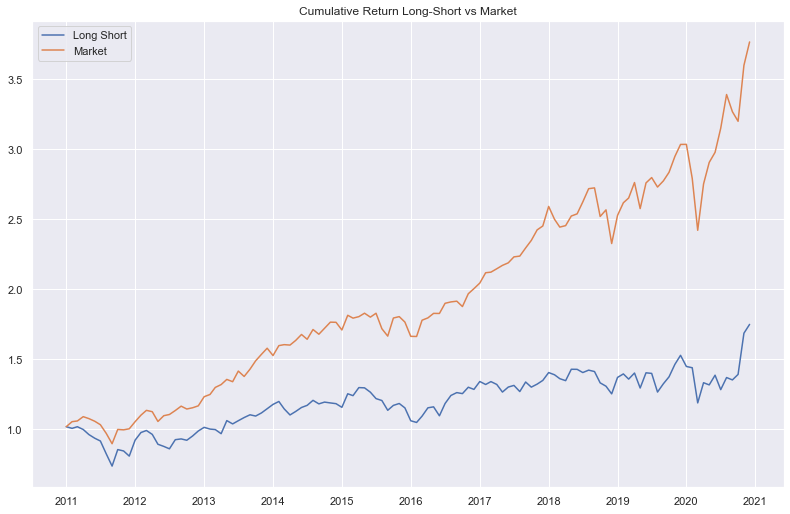

In [345]:
x = plotting_df['date']
y = plotting_df[['Cumulative Return','Cumulative Return Market']]
plt.figure(figsize=(12, 8))
plt.plot(x, y)
plt.title('Cumulative Return Long-Short vs Market')
plt.legend(['Long Short' ,'Market'])
plt.show()

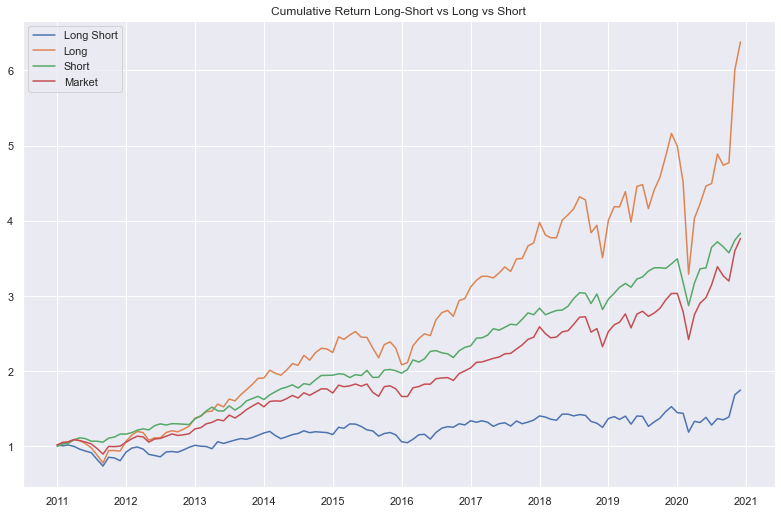

In [355]:
x = plotting_df['date']
y = plotting_df[['Cumulative Return','Cumulative Return Long','Cumulative Return Short','Cumulative Return Market']]
plt.figure(figsize=(12, 8))
plt.plot(x, y)
plt.title('Cumulative Return Long-Short vs Long vs Short')
plt.legend(['Long Short' ,'Long','Short','Market'])
plt.show()

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!DONE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


Shout out to Eric if he actually read all the way to the bottom. We appreciate the rigor.